In [1]:
import numpy as np

from scipy.stats import norm
from tqdm import tqdm

import time as t
import pickle

from plot_functions import *

# Load data

In [2]:
name = "NPE_C_nsf_uni"

In [3]:
global_params = np.array([[-2.3, -2.89], [0.3, 0.3]])

In [4]:
# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y

In [5]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [6]:
# CHEMPY data with alternative yields
data_alternative_yields = np.load("data/chempy_data/chempy_alternative_yields.npz", mmap_mode='r')

elements = data_alternative_yields['elements']
alt_x = data_alternative_yields['params']
alt_y = data_alternative_yields['abundances']

alt_x, alt_y = clean_data(alt_x, alt_y)

# Remove H from data, because it is just used for normalization (output with index 2)
elements = np.delete(elements, 2)
alt_y = np.delete(alt_y, 2, 1)

alt_y_obs = add_noise(alt_y)

In [7]:
# TNG simulation data
data_tng = np.load("data/chempy_data_paper/Mock_Data_TNG.npz", mmap_mode='r')

tng_y = data_tng['true_abuns']

tng_y_obs = add_noise(tng_y)

# Load posterior

In [8]:
# ----- Load posterior -----
with open(f'data/posterior_{name}.pickle', 'rb') as f:
    posterior = pickle.load(f)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/export/home/bguenes/envs/master_chempy_multi/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

# Inference
### 1. Alternative yield set

In [9]:
alpha_IMF_alt_obs = []
log10_N_Ia_alt_obs = []
simulations = 1000
N_stars = len(alt_y_obs)

start = t.time()
for i in tqdm(range(len(alt_y_obs))):
    x = add_noise(alt_y_obs[i])
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_alt_obs.append(alpha)
    log10_N_Ia_alt_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_alt_obs = np.array(alpha_IMF_alt_obs)
log10_N_Ia_alt_obs = np.array(log10_N_Ia_alt_obs)

  0%|          | 0/999 [00:00<?, ?it/s]/export/home/bguenes/envs/master_chempy_multi/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(
100%|██████████| 999/999 [00:49<00:00, 20.34it/s]

Time to run 1000 simulations for 999 stars: 49.115 s


### 2. TNG simulation 

In [10]:
alpha_IMF_tng_obs = []
log10_N_Ia_tng_obs = []
simulations = 1000
N_stars = len(tng_y_obs)

start = t.time()
for i in tqdm(range(len(tng_y_obs))):
    x = add_noise(tng_y_obs[i])
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_tng_obs.append(alpha)
    log10_N_Ia_tng_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_tng_obs = np.array(alpha_IMF_tng_obs)
log10_N_Ia_tng_obs = np.array(log10_N_Ia_tng_obs)

 44%|████▎     | 437/1000 [00:40<00:25, 22.11it/s]WARNING:root:Only 0.044% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    -3 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 77%|███████▋  | 770/1000 [02:22<00:42,  5.40it/s]


KeyboardInterrupt: 

# Plot

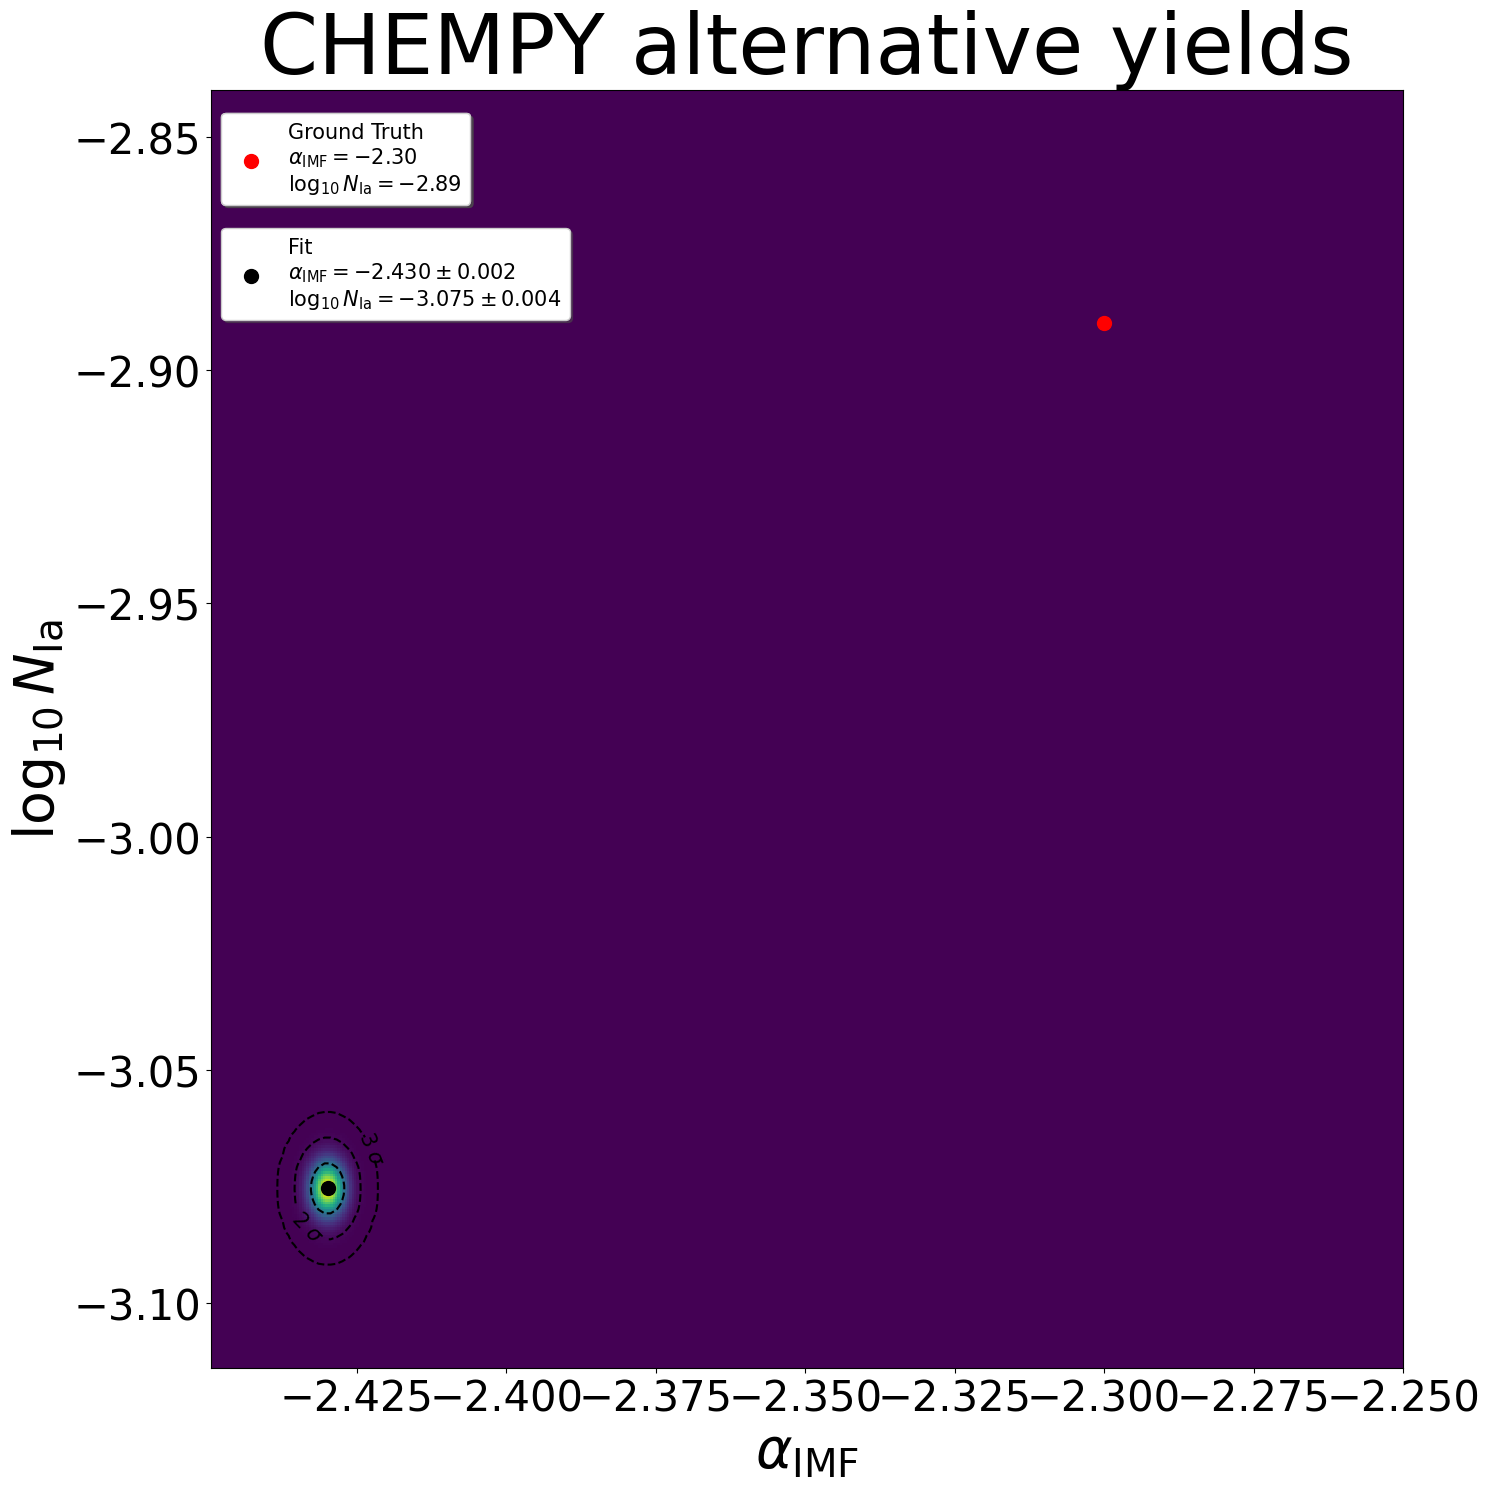

In [11]:
gaussian_posterior_plot(alpha_IMF_alt_obs, log10_N_Ia_alt_obs, global_params, title="CHEMPY alternative yields")

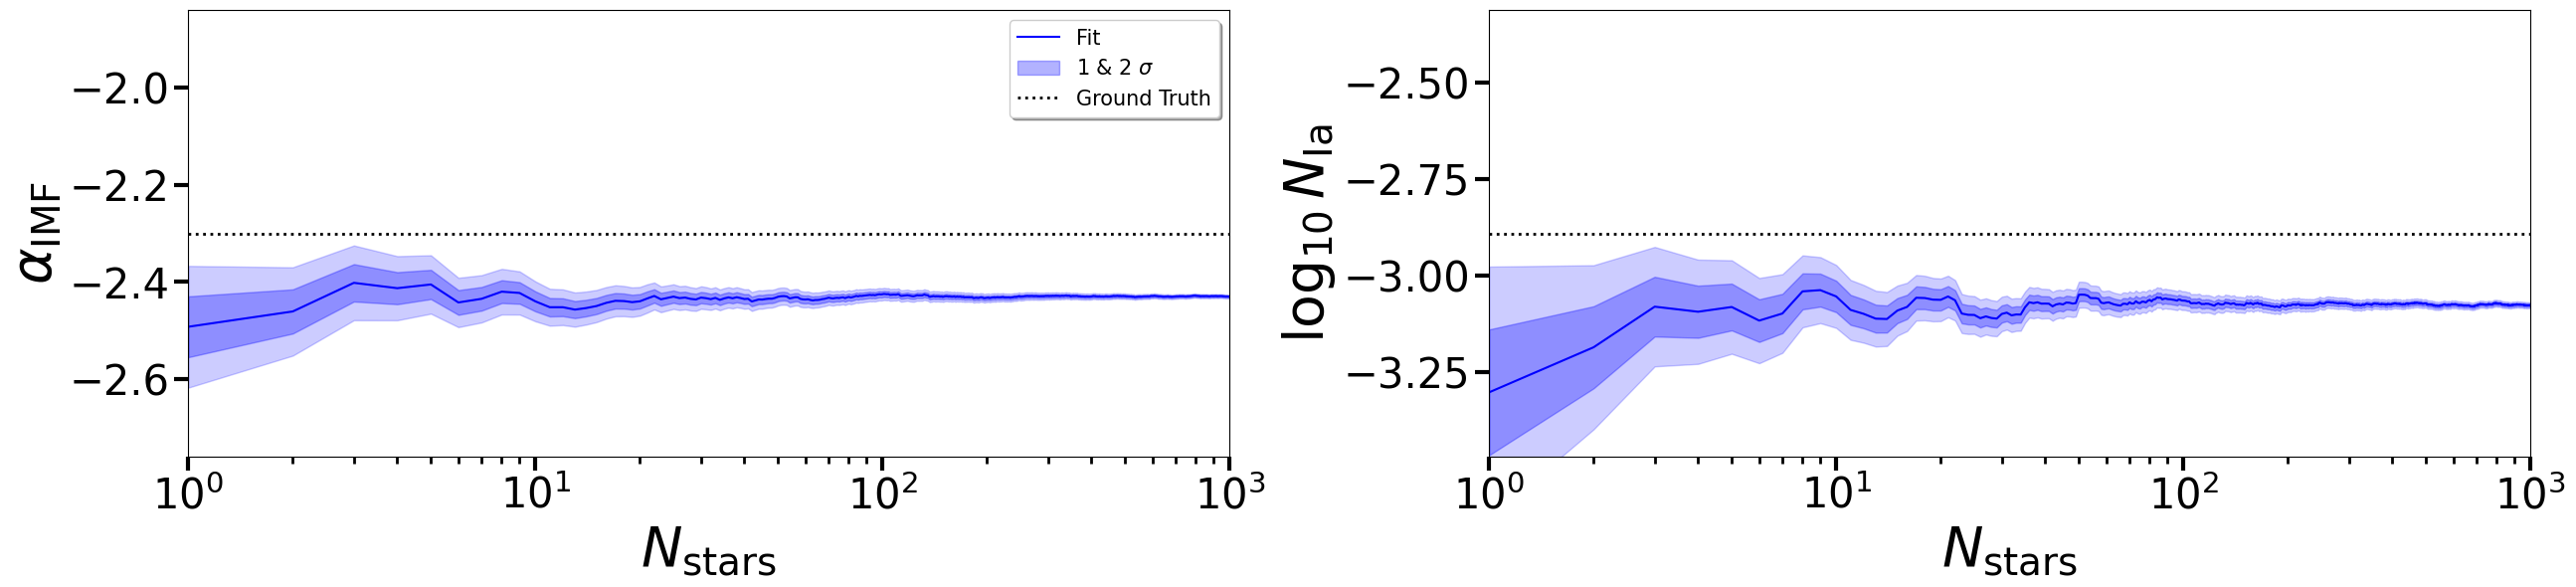

In [12]:
stars = np.arange(1,len(alt_y_obs))
n_stars_plot(alpha_IMF_alt_obs, log10_N_Ia_alt_obs, global_params, "CHEMPY alternative yields N_star", stars)

In [13]:
alpha_IMF_tng_obs = np.array(alpha_IMF_tng_obs)
log10_N_Ia_tng_obs = np.array(log10_N_Ia_tng_obs)

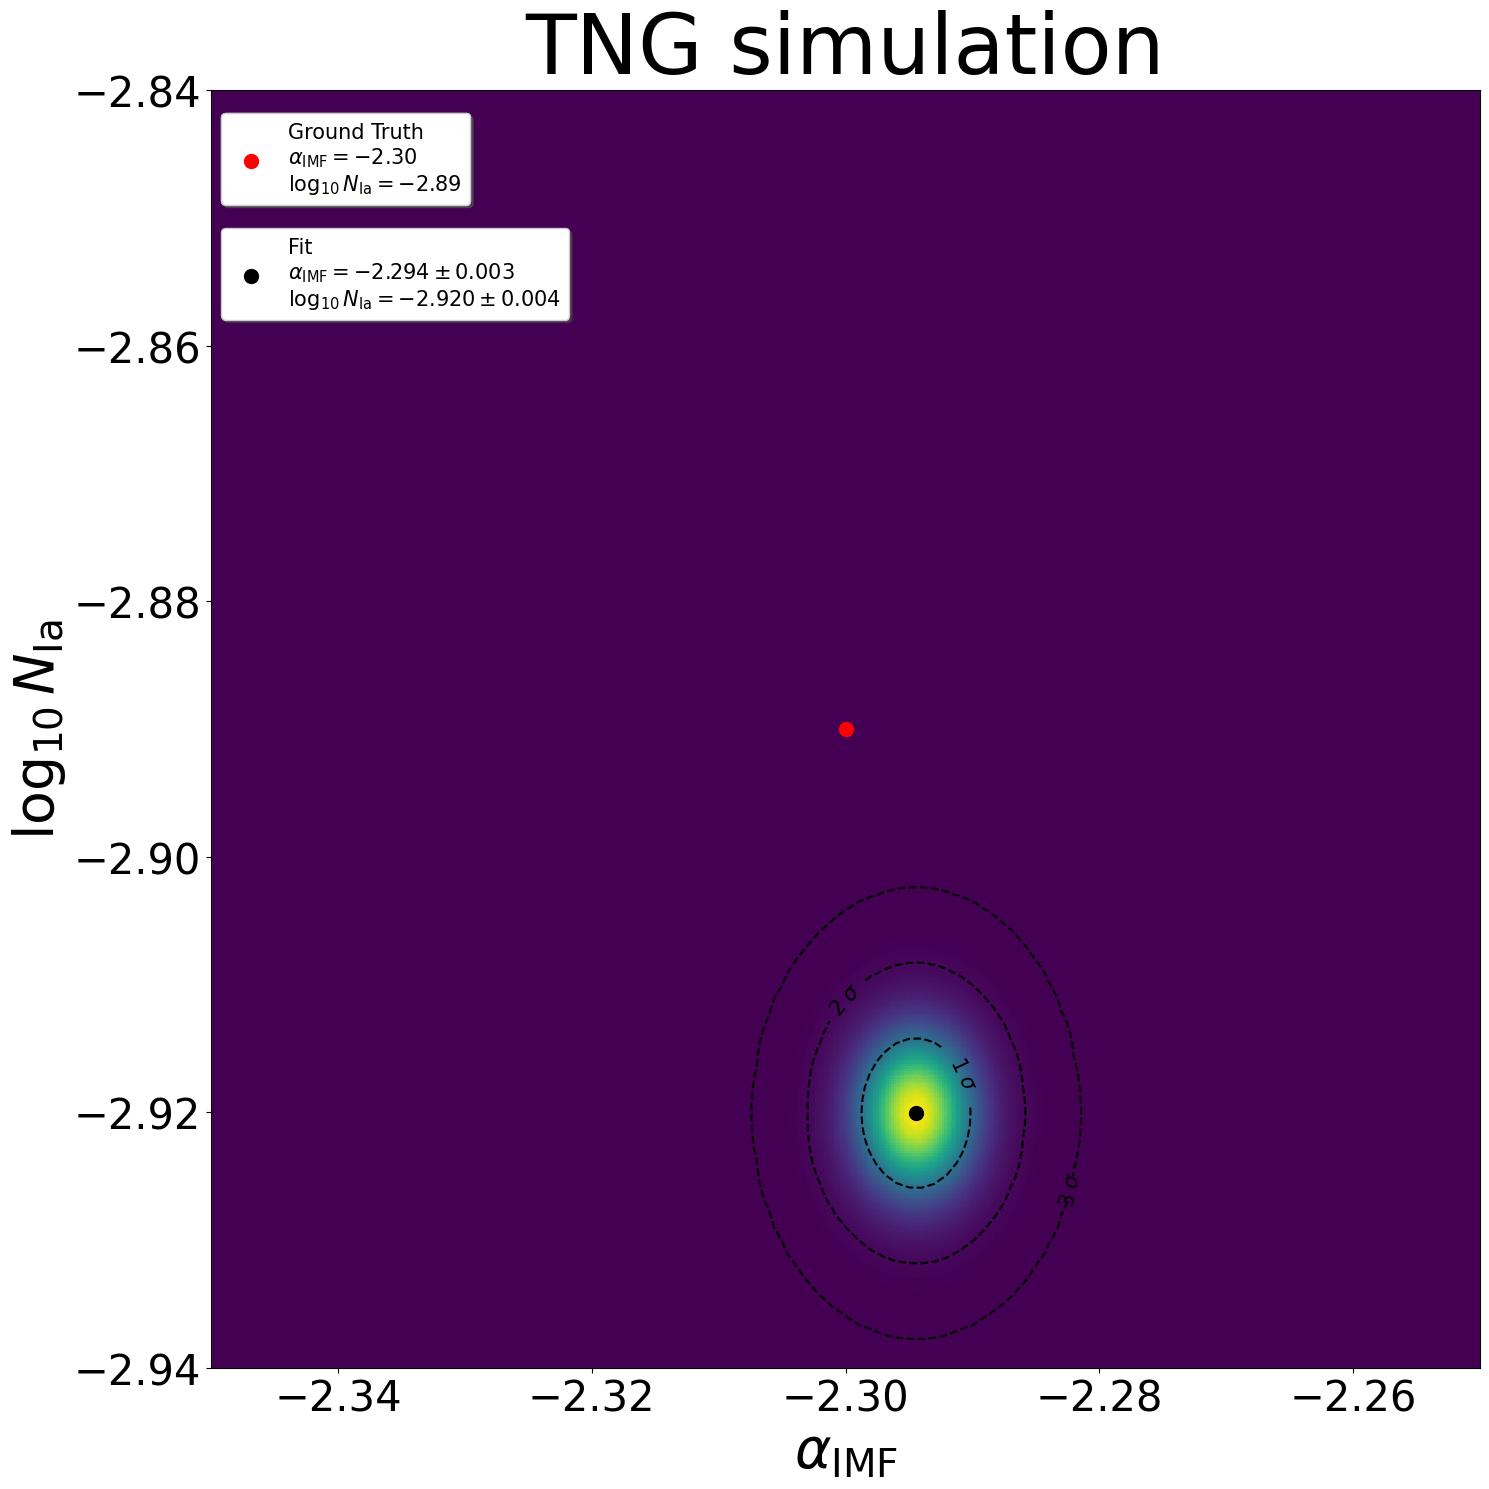

In [14]:
gaussian_posterior_plot(alpha_IMF_tng_obs, log10_N_Ia_tng_obs, global_params, title="TNG simulation")

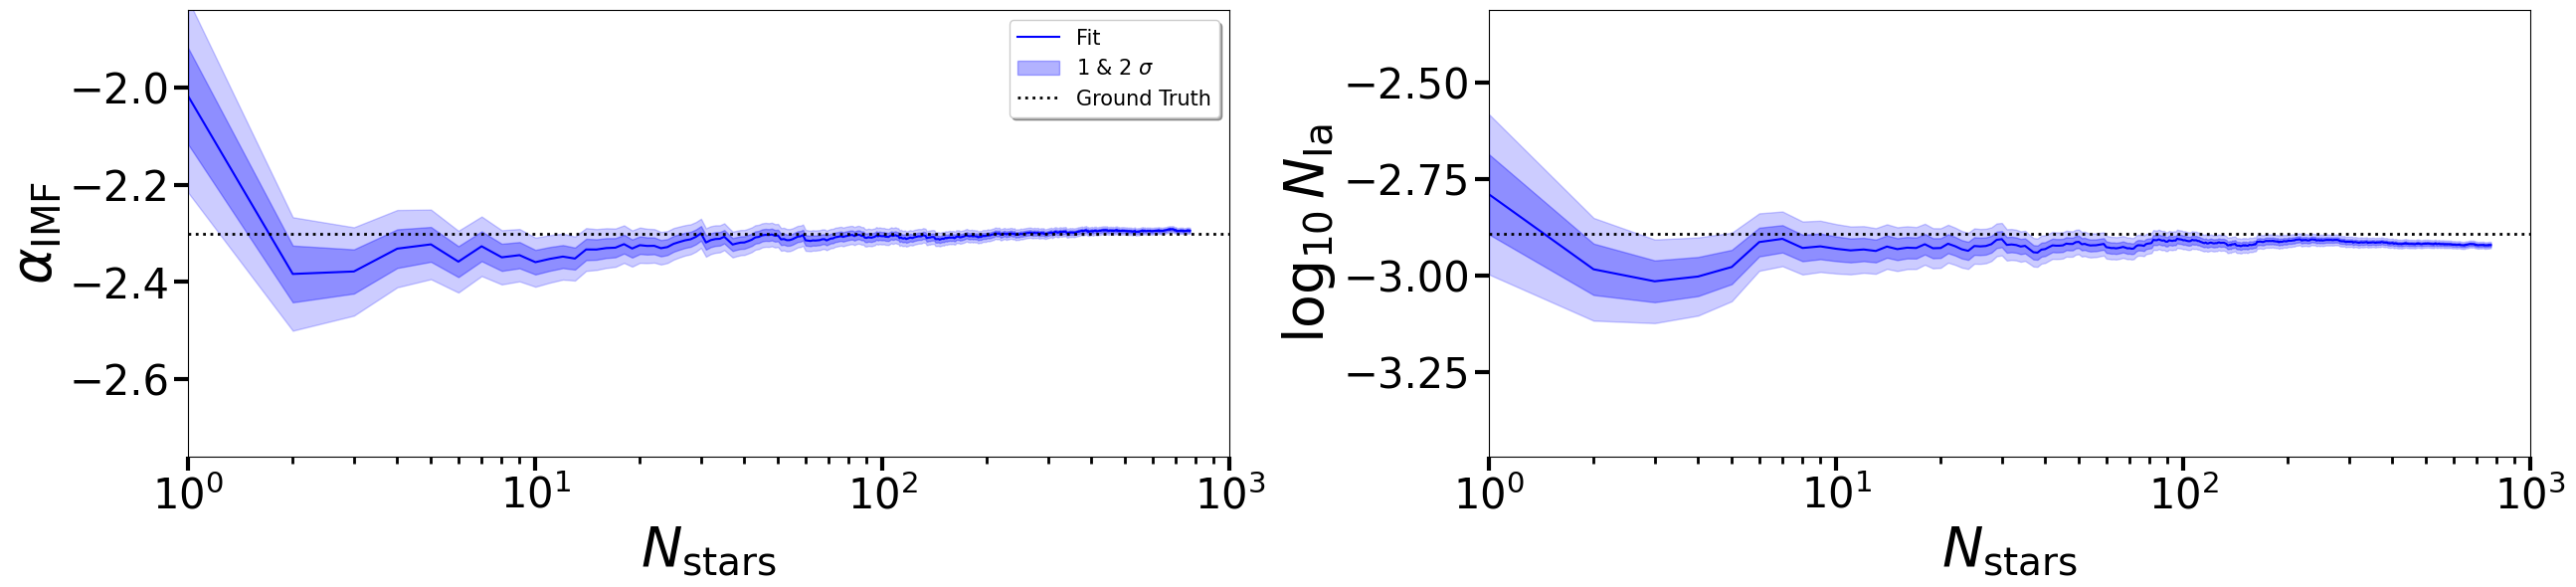

In [15]:
stars = np.arange(1,len(alpha_IMF_tng_obs))
n_stars_plot(alpha_IMF_tng_obs, log10_N_Ia_tng_obs, global_params, "TNG simulation N_star", stars)